In [1]:
import xarray as xr
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = xr.open_mfdataset('./data/all_5.625deg/2m_temperature/2m_temperature_*.nc')
data.chunk(50000)

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(50000, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [28]:
d = data.t2m.sel(lat=-87.1875, lon=0., time="1979-01-01", method="nearest")
d

<xarray.DataArray 't2m' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lon      float64 0.0
    lat      float64 -87.19
    time     datetime64[ns] 1979-01-01
Attributes:
    units:      K
    long_name:  2 metre temperature

In [3]:
import networkx as nx

In [4]:
R = 6371
mean_lon = np.mean(data.coords['lon'].values)
mean_lat = np.mean(data.coords['lon'].values)
coords = []
all_points = []
for lat in data.coords['lat'].values:
    for lon in data.coords['lon'].values:
        all_points.append((lat,lon))
        # all_points.append((lon, lat))
all_points = np.array(all_points)

In [31]:
np.min(data.coords['lat'].values), np.max(data.coords['lat'].values)

(-87.1875, 87.1875)

In [7]:
import pyproj
def pyproj_xyz(lat, lon, R):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    return pyproj.transform(lla, ecef, lon, lat, R)


def pyproj_coords(x, y, z):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    
    lon, lat, r =  pyproj.transform(ecef, lla, x, y, z,)
    return lat, lon, r

In [8]:
cart_points = []
for point in all_points:
    cart_points.append(pyproj_xyz(point[0], point[1], R))
cart_points = np.array(cart_points)

In [9]:
def convert_to_coords(x,y,z):
    p = pyproj_coords(x,y,z)
    return (np.round(p[0], 4), np.round((p[1] + 360) % 360, 4))

In [10]:
converted_back = []
for c_p in cart_points:
    converted_back.append(convert_to_coords(*c_p))

In [11]:
def check_existance_of_neighbours(neighbours, all_nodes):
    _neighbours = np.empty(len(neighbours), dtype=object)
    _neighbours[:] = neighbours
    
    _all_nodes = np.empty(len(all_nodes), dtype=object)
    _all_nodes[:] = all_nodes
    evaluation = [neigh in list(_all_nodes) for neigh in _neighbours]
    return np.all(evaluation) 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

nodes_as_tuples = [tuple(p) for p in all_points]
for pt in converted_back:
    if not check_existance_of_neighbours([pt], nodes_as_tuples):
        # raise Exception(f"{pt}: \n doesnt exist among nodes")
        print(f"Point {pt} isnt among nodes, trying to get nearest {find_nearest(np.array(nodes_as_tuples)[:, 0], pt[0])}, {find_nearest(np.array(nodes_as_tuples)[:, 1], pt[1])}")

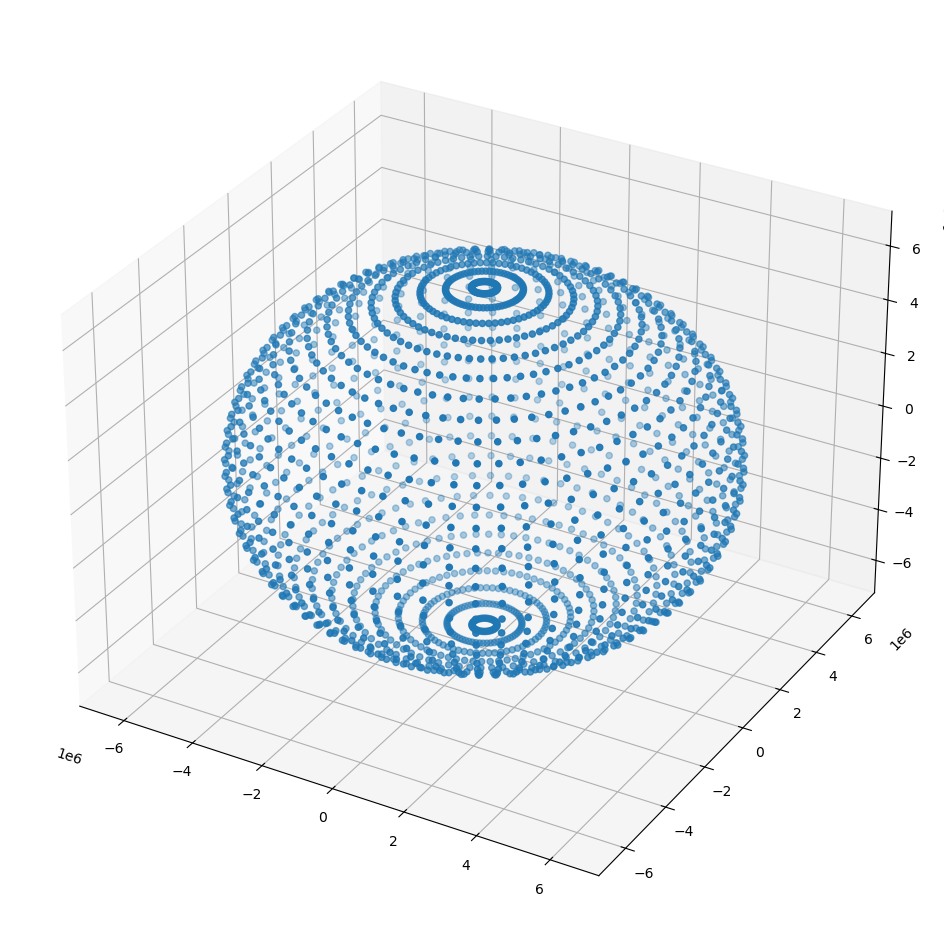

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(cart_points[:, 0], cart_points[:, 1], cart_points[:, 2])

In [13]:
# cart_points[:, 0], cart_points[:, 1], cart_points[:, 2]
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=9, algorithm='brute')
knn.fit(cart_points)
nearest_neighbours = knn.kneighbors(cart_points)

In [14]:
cart_points.shape
tuple_cart_points = [tuple(p) for p in cart_points]

In [15]:
_points_cart = np.empty(len(tuple_cart_points), dtype=object)
_points_cart[:] = tuple_cart_points

In [17]:
from geopy import distance

# distance.distance(p1, p2).meters, distance.geodesic(p1, p2, ellipsoid="WGS-84").meters
coord_edges = []
coord_nodes = []
for i in range(len(tuple_cart_points)):
    point = tuple_cart_points[i]
    neighbours_indices = nearest_neighbours[1][i]
    ngbs = _points_cart[neighbours_indices]
    coord_point = convert_to_coords(*point)
    nb_coords = [convert_to_coords(*nb) for nb in ngbs]
    neighbours_distances = [distance.distance(coord_point, nb).meters for nb in nb_coords]
    edges_coord = [(coord_point, neighbour, {'distance': distnc}) for neighbour, distnc in zip(nb_coords, neighbours_distances)]
    coord_edges.append(edges_coord)
    coord_nodes.append(coord_point)

In [18]:
# sphere_graph = nx.Graph()
# sphere_graph.add_nodes_from(tuple_cart_points)
# for edge in cartesian_edges:
#     sphere_graph.add_edges_from(edge)

sphere_graph = nx.Graph()
sphere_graph.add_nodes_from(coord_nodes)
for edge in coord_edges:
    sphere_graph.add_edges_from(edge)

In [34]:
coord_edges

[[((-87.1875, 0.0), (-87.1875, 0.0), {'distance': 0.0}),
  ((-87.1875, 0.0), (-87.1875, 5.625), {'distance': 30815.572256973952}),
  ((-87.1875, 0.0), (-87.1875, 354.375), {'distance': 30815.572256973952}),
  ((-87.1875, 0.0), (-87.1875, 11.25), {'distance': 61557.08494454576}),
  ((-87.1875, 0.0), (-87.1875, 348.75), {'distance': 61557.08494454576}),
  ((-87.1875, 0.0), (-87.1875, 16.875), {'distance': 92150.65306861217}),
  ((-87.1875, 0.0), (-87.1875, 343.125), {'distance': 92150.65306861217}),
  ((-87.1875, 0.0), (-87.1875, 337.5), {'distance': 122522.74044769681}),
  ((-87.1875, 0.0), (-87.1875, 22.5), {'distance': 122522.74044769681})],
 [((-87.1875, 5.625), (-87.1875, 5.625), {'distance': 0.0}),
  ((-87.1875, 5.625), (-87.1875, 11.25), {'distance': 30815.572256973952}),
  ((-87.1875, 5.625), (-87.1875, 0.0), {'distance': 30815.572256973952}),
  ((-87.1875, 5.625), (-87.1875, 354.375), {'distance': 61557.08494454576}),
  ((-87.1875, 5.625), (-87.1875, 16.875), {'distance': 61557.

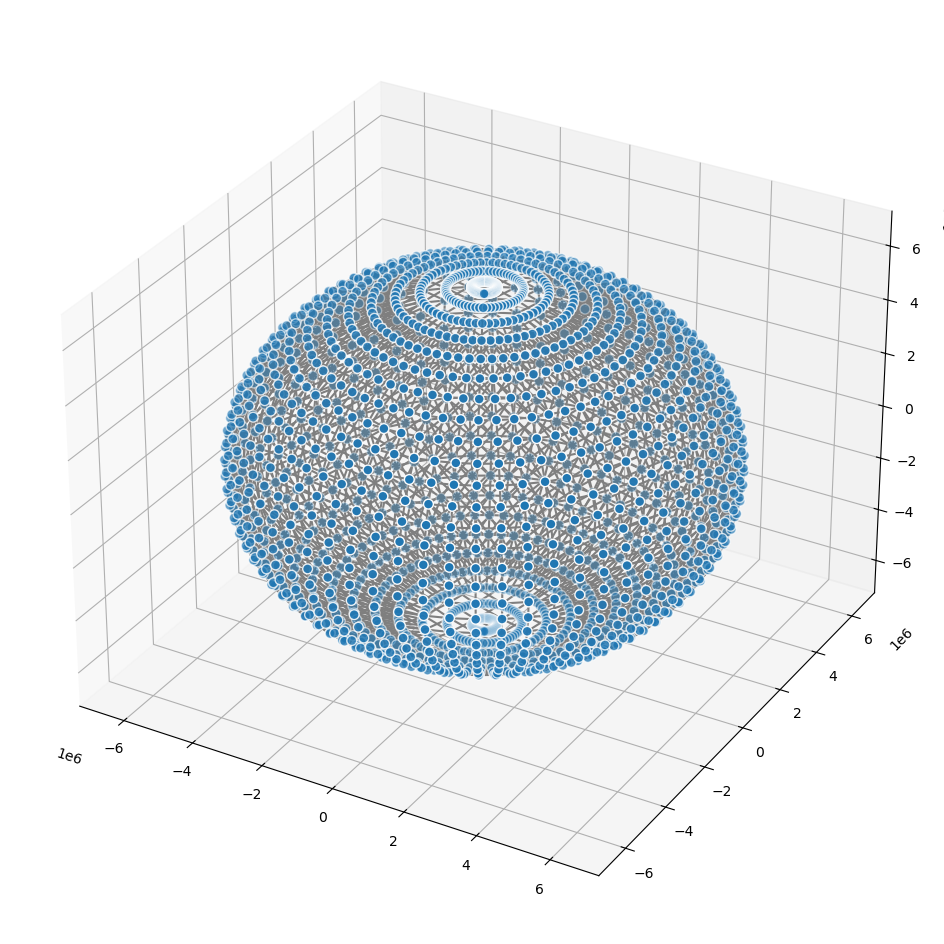

In [19]:

node_xyz = np.array([pyproj_xyz(*v, R) for v in sphere_graph])
sphere_edge = np.array([(pyproj_xyz(*u, R), pyproj_xyz(*v, R)) for u,v in sphere_graph.edges()])

fig2 = plt.figure(figsize=(12, 12))
ax2 = fig2.add_subplot(projection='3d')

ax2.scatter(*node_xyz.T, s=50, ec="w")
for vizedge in sphere_edge:
    ax2.plot(*vizedge.T, color="tab:gray")

In [58]:
import pickle

pickle.dump(sphere_graph, open('./sphere_graph.pickle', 'wb'))

In [20]:
# nx.get_edge_attributes(sphere_graph, 'distance')
dtype = np.dtype([('distance', float)])
adj_distances = nx.to_numpy_array(sphere_graph, dtype=dtype, weight=None)

In [33]:
adj_distances

array([[(    0.        ,), (30815.57225697,), (61557.08494455,), ...,
        (    0.        ,), (    0.        ,), (    0.        ,)],
       [(30815.57225697,), (    0.        ,), (30815.57225697,), ...,
        (    0.        ,), (    0.        ,), (    0.        ,)],
       [(61557.08494455,), (30815.57225697,), (    0.        ,), ...,
        (    0.        ,), (    0.        ,), (    0.        ,)],
       ...,
       [(    0.        ,), (    0.        ,), (    0.        ,), ...,
        (    0.        ,), (30815.57225697,), (61557.08494455,)],
       [(    0.        ,), (    0.        ,), (    0.        ,), ...,
        (30815.57225697,), (    0.        ,), (30815.57225697,)],
       [(    0.        ,), (    0.        ,), (    0.        ,), ...,
        (61557.08494455,), (30815.57225697,), (    0.        ,)]],
      dtype=[('distance', '<f8')])

In [24]:
min, max

(0.0, 882408.2705029473)

In [21]:
min, max =adj_distances['distance'].min(), adj_distances['distance'].max()
normalized_distances = (adj_distances['distance'] - min) / (max - min)

In [43]:
adj_distances['distance'].min(), adj_distances['distance'][adj_distances['distance'] != 882408.2705029473].max()

(0.0, 880322.510762166)

In [46]:
max1 = 882408.2705029473
max2 = 880322.510762166

percentage = (max2 * 100) / max1

In [39]:
inverted_dist = 1 / adj_distances['distance']
inverted_dist[inverted_dist == np.inf] = 1
inverted_dist.min(), inverted_dist.max()

min = inverted_dist.min()
max = inverted_dist.max()
normalzed_distance_weights = (inverted_dist - min) / (max - min)

In [47]:
second_min, max = normalzed_distance_weights[normalzed_distance_weights != 0].min(), normalzed_distance_weights.max()
second_min, max

(2.6850562936210886e-09, 1.0)

In [57]:
first_min = (percentage * second_min) / 100

first_min

2.6787095916395057e-09

In [73]:
edge_frame = nx.to_pandas_edgelist(sphere_graph)
dist = edge_frame['distance'].values
inverted_dist = 1 / dist
inverted_dist[inverted_dist == np.inf] = 1
min, max = inverted_dist.min(), inverted_dist.max()
normed_dist_weigts = (inverted_dist - min) / (max - min)

second_min, norm_max = normed_dist_weigts[normed_dist_weigts != 0].min(), normed_dist_weigts.max()
first_min = (percentage * second_min) / 100
normed_dist_weigts[normed_dist_weigts == 0] = first_min
normed_dist_weigts
edge_frame['distance'] = normed_dist_weigts
edge_frame

,source,target,distance
0,"(-87.1875, 0.0)","(-87.1875, 0.0)",1.000000
1,"(-87.1875, 0.0)","(-87.1875, 5.625)",0.000031
2,"(-87.1875, 0.0)","(-87.1875, 354.375)",0.000031
3,"(-87.1875, 0.0)","(-87.1875, 11.25)",0.000015
4,"(-87.1875, 0.0)","(-87.1875, 348.75)",0.000015
...,...,...,...
10683,"(87.1875, 343.125)","(87.1875, 348.75)",0.000031
10684,"(87.1875, 343.125)","(87.1875, 354.375)",0.000015
10685,"(87.1875, 348.75)","(87.1875, 348.75)",1.000000
10686,"(87.1875, 348.75)","(87.1875, 354.375)",0.000031


<Axes: xlabel='distance'>

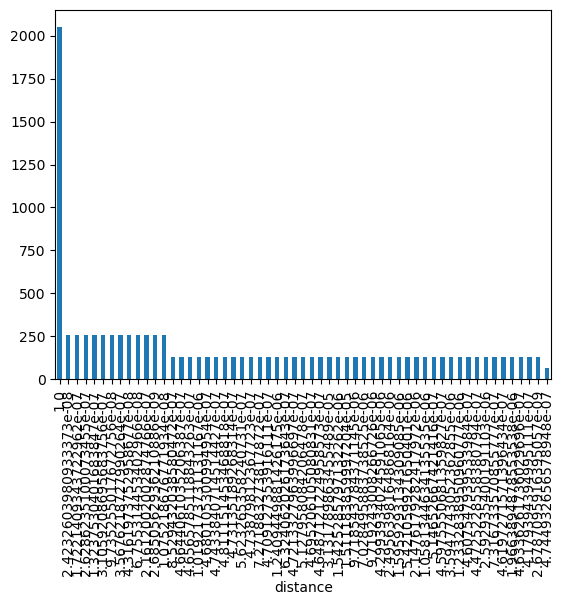

In [78]:
edge_frame['distance'].value_counts().plot.bar()

In [88]:
sphere_graph_weighted = nx.from_pandas_edgelist(edge_frame, edge_attr='distance')

In [89]:
nx.to_pandas_edgelist(sphere_graph_weighted)

,source,target,distance
0,"(-87.1875, 0.0)","(-87.1875, 0.0)",1.000000
1,"(-87.1875, 0.0)","(-87.1875, 5.625)",0.000031
2,"(-87.1875, 0.0)","(-87.1875, 354.375)",0.000031
3,"(-87.1875, 0.0)","(-87.1875, 11.25)",0.000015
4,"(-87.1875, 0.0)","(-87.1875, 348.75)",0.000015
...,...,...,...
10683,"(87.1875, 320.625)","(87.1875, 326.25)",0.000031
10684,"(87.1875, 320.625)","(87.1875, 331.875)",0.000015
10685,"(87.1875, 326.25)","(87.1875, 326.25)",1.000000
10686,"(87.1875, 326.25)","(87.1875, 331.875)",0.000031


In [90]:
import pickle
pickle.dump(sphere_graph_weighted, open('./sphere_graph_weighted.pickle', 'wb'))

In [61]:
normalzed_distance_weights.min(), normalzed_distance_weights.max()

(2.6787095916395057e-09, 1.0)

In [63]:
# sphere_graph.update()
# set normalized weights here

In [60]:
normalized_distances.min(), normalized_distances.max()

(0.0, 1.0)

In [28]:
inverse_distance = 1 / normalized_distances

In [32]:
inverse_distance.min(), inverse_distance[inverse_distance != np.inf].max()

(1.0, 28.635141452005556)

In [47]:
adjacency_matrix = nx.adjacency_matrix(sphere_graph).todense()
idx_selectors = np.where(adjacency_matrix > 0)

In [48]:
to_replace = normalized_distances[idx_selectors]

In [49]:
to_replace[to_replace == 0] = 1

In [70]:
normalized_distances[idx_selectors] = to_replace
normalized_distances

array([[1.        , 0.03492213, 0.06976032, ..., 0.        , 0.        ,
        0.        ],
       [0.03492213, 1.        , 0.03492213, ..., 0.        , 0.        ,
        0.        ],
       [0.06976032, 0.03492213, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.03492213,
        0.06976032],
       [0.        , 0.        , 0.        , ..., 0.03492213, 1.        ,
        0.03492213],
       [0.        , 0.        , 0.        , ..., 0.06976032, 0.03492213,
        1.        ]])

In [25]:
edge_frame = nx.to_pandas_edgelist(sphere_graph)
# edge_frame['norm_distance'] = (edge_frame['distance'] - min) / (max - min)
edge_frame

,source,target,distance
0,"(-87.1875, 0.0)","(-87.1875, 0.0)",0.000000
1,"(-87.1875, 0.0)","(-87.1875, 5.625)",30815.572257
2,"(-87.1875, 0.0)","(-87.1875, 354.375)",30815.572257
3,"(-87.1875, 0.0)","(-87.1875, 11.25)",61557.084945
4,"(-87.1875, 0.0)","(-87.1875, 348.75)",61557.084945
...,...,...,...
10683,"(87.1875, 343.125)","(87.1875, 348.75)",30815.572257
10684,"(87.1875, 343.125)","(87.1875, 354.375)",61557.084945
10685,"(87.1875, 348.75)","(87.1875, 348.75)",0.000000
10686,"(87.1875, 348.75)","(87.1875, 354.375)",30815.572257


In [84]:
len(nx.to_pandas_adjacency(sphere_graph))

2048

In [87]:
edge_frame['norm_distance'].values[edge_frame['norm_distance'].values == 0] = 1

In [88]:
edge_frame

,source,target,distance,norm_distance
0,"(-87.1875, 0.0)","(-87.1875, 0.0)",0.000000,1.000000
1,"(-87.1875, 0.0)","(-87.1875, 5.625)",30815.572257,0.034922
2,"(-87.1875, 0.0)","(-87.1875, 354.375)",30815.572257,0.034922
3,"(-87.1875, 0.0)","(-87.1875, 11.25)",61557.084945,0.069760
4,"(-87.1875, 0.0)","(-87.1875, 348.75)",61557.084945,0.069760
...,...,...,...,...
10683,"(87.1875, 343.125)","(87.1875, 348.75)",30815.572257,0.034922
10684,"(87.1875, 343.125)","(87.1875, 354.375)",61557.084945,0.069760
10685,"(87.1875, 348.75)","(87.1875, 348.75)",0.000000,1.000000
10686,"(87.1875, 348.75)","(87.1875, 354.375)",30815.572257,0.034922
